In [82]:
from classes import *
from utils import *
import math

from typing import List, Set, Tuple, Any, Dict, DefaultDict, Optional
from collections import defaultdict
import linearize_io_helper as io_helper

%load_ext nb_black
%load_ext autoreload
%autoreload 2

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [113]:
def linearize_io(spec: List[Call]):
    sort_by_var: DefaultDict[int, List[Call]] = defaultdict(list)
    false_cases: List[CallCAS] = []
    true_cases: List[CallCAS] = []
    
    io_helper.populate_call_bins(spec, sort_by_var, true_cases, false_cases)
    
    writes = io_helper.basic_io_checks(sort_by_var)
    if writes is None:
        return False 
    
    if not io_helper.basic_true_cas_checks(true_cases):
        return False
    
    io_helper.topological_true_cas_sort(true_cases)

    true_cas_var_groups: List[List[int]] = []
    for true_cas in true_cases:
        for group in true_cas_var_groups:
            if true_cas.compare == group[-1]:
                group.append(true_cas.swap)
                break
        else:
            true_cas_var_groups.append([true_cas.compare, true_cas.swap])


    true_cas_call_groups: List[List[Call]] = []
    for group in true_cas_var_groups:
        all_group_ops: List[Call] = []
        for var in group:
            all_group_ops.extend(sort_by_var[var])
        all_group_ops = list(dict.fromkeys(all_group_ops))
        true_cas_call_groups.append(all_group_ops)

    # intra-group check
    for group_i in range(len(true_cas_var_groups)):
        intra_group_bins = defaultdict(list)
        io_helper.populate_call_bins(true_cas_call_groups[group_i], intra_group_bins, [], [])
        intra_group_intervals = io_helper.make_intervals(intra_group_bins)
        order = true_cas_var_groups[group_i]
        if io_helper.true_cas_intra_group_check(intra_group_intervals, order) is not True:
            return False
       

    # inter-group check
    for var_group in true_cas_var_groups:
        var = var_group[0]
        for other_var in var_group[1:]:
            sort_by_var[var].extend(sort_by_var[other_var])
            del sort_by_var[other_var]

    intervals: Dict[int, I] = io_helper.make_intervals(sort_by_var)

    blocks = io_helper.make_blocks(sort_by_var, intervals)

    if not io_helper.io_check(intervals):
        return False
    
    ##### ASSUMPTION: Intervals do not intersect #####
    # then blocks will all be disjoint ex. [[0], [1], [2]]
    # we can straight up sort the blocks by their first element
    

    false_cas_var_resolver: Dict[CallCAS, List[int]] = {}
    false_cases.sort(key=lambda x: x.end)
    for false_cas in false_cases:
        available_writes : List[int] = [] 
        block_i = 0

        while block_i < len(blocks):
            block = blocks[block_i]
            writes_in_block = {var for var in block if writes[var].start < false_cas.end}

            assert len(writes_in_block) in (0,1)

            if min((min(c.end for c in sort_by_var[var]) for var in block)) < false_cas.start:
                available_writes.clear()

            available_writes.extend(writes_in_block)

            if len(writes_in_block) == 0:
                break

            var = next(iter(writes_in_block))
            interval = intervals[var]
            if interval.reversed:
                line = interval.start
            else:
                line = interval.end

            if false_cas.end > line:
                block_i += 1
            else:
                break
            
        if false_cas.compare in available_writes:
            available_writes.remove(false_cas.compare)
        
        false_cas_var_resolver[false_cas] = available_writes
    
    # print(blocks)
    # print({f"{k} ({k.start} - {k.end})":v for k,v in false_cas_var_resolver.items()})

    visited : Dict[int, I] = {}
    for false_cas in false_cases.copy():
        for var in false_cas_var_resolver[false_cas]:
            if var in visited:
                if I(false_cas.start, false_cas.end).contained_in(visited[var]):
                    false_cas_var_resolver[false_cas].remove(var)

        if false_cas.compare not in visited:
            if false_cas.compare in writes:
                if false_cas.end < writes[false_cas.compare].start:
                    visited[false_cas.compare] = I(false_cas.end, writes[false_cas.compare].start)
                elif false_cas.start > writes[false_cas.compare].end:
                    visited[false_cas.compare] = I(false_cas.end, math.inf)
        if len(false_cas_var_resolver[false_cas]) == 0:
            return false_cas.compare

    return True


<IPython.core.display.Javascript object>

In [3]:
# generate_tests()

<IPython.core.display.Javascript object>

In [89]:
test = load_test("testcasfalse.pkl")

<IPython.core.display.Javascript object>

In [90]:
def run_test(testsample: List[Tuple[List[Call], bool]]):
    wrong_test_no = []
    for i in tqdm.tqdm(range(len(testsample))):
        testcase, res = copy.deepcopy(testsample[i])
        try:
            sol = linearize_io(testcase)
            s2 = (sol is True)
            if res ^ s2:
                wrong_test_no.append(i)

        except AssertionError as e:
            raise e

    print(f"Tests failed: {len(wrong_test_no)}")
    if len(wrong_test_no) == 0:
        print("All tests passed")
    else:
        print(f"First failed: {wrong_test_no}")
    
    return wrong_test_no

<IPython.core.display.Javascript object>

In [91]:
# lets filter those test cases where the intervals are not overlapping
non_overlapping : List[Tuple[List[Call], bool]] = []
for testcase, res in tqdm.tqdm(test):
    sort_by_var = defaultdict(list)
    io_helper.populate_call_bins(testcase, sort_by_var, [], [])
    intervals = io_helper.make_intervals(sort_by_var)
    flag = True
    for i in intervals.values():
        for j in intervals.values():
            if i != j and i.intersects(j):
                flag = False
                break
    if flag:
        non_overlapping.append((testcase, res))
    
test = non_overlapping

100%|██████████| 50000/50000 [00:03<00:00, 13442.25it/s]


<IPython.core.display.Javascript object>

In [111]:
wrong_test_no = run_test(non_overlapping)

100%|██████████| 2777/2777 [00:01<00:00, 1571.13it/s]

Tests failed: 0
All tests passed


<IPython.core.display.Javascript object>

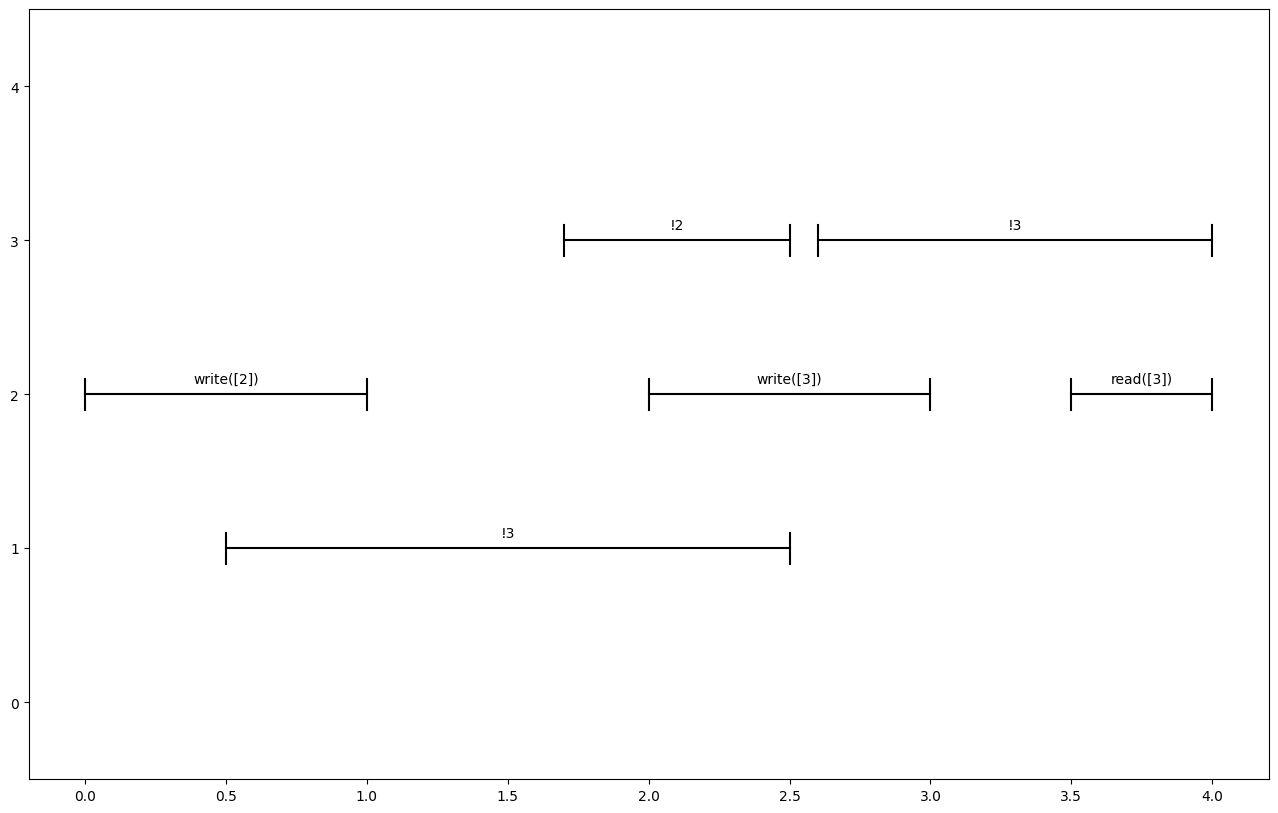

None
3


<IPython.core.display.Javascript object>

In [112]:
test = [
    CallWrite(2, 2, 0, 1),
    CallWrite(2, 3, 2, 3),
    CallRead(2, 3, 3.5, 4),
    CallCAS(1, False, 3, 0, 0.5, 2.5),
    CallCAS(3, False, 2, 0, 1.7, 2.5),
    CallCAS(3, False, 3, 0, 2.6, 4)
]
visualize_history(test)
print(linearize_generic(test, StateIO()))
print(linearize_io(test))

Testcase 28 is True
True


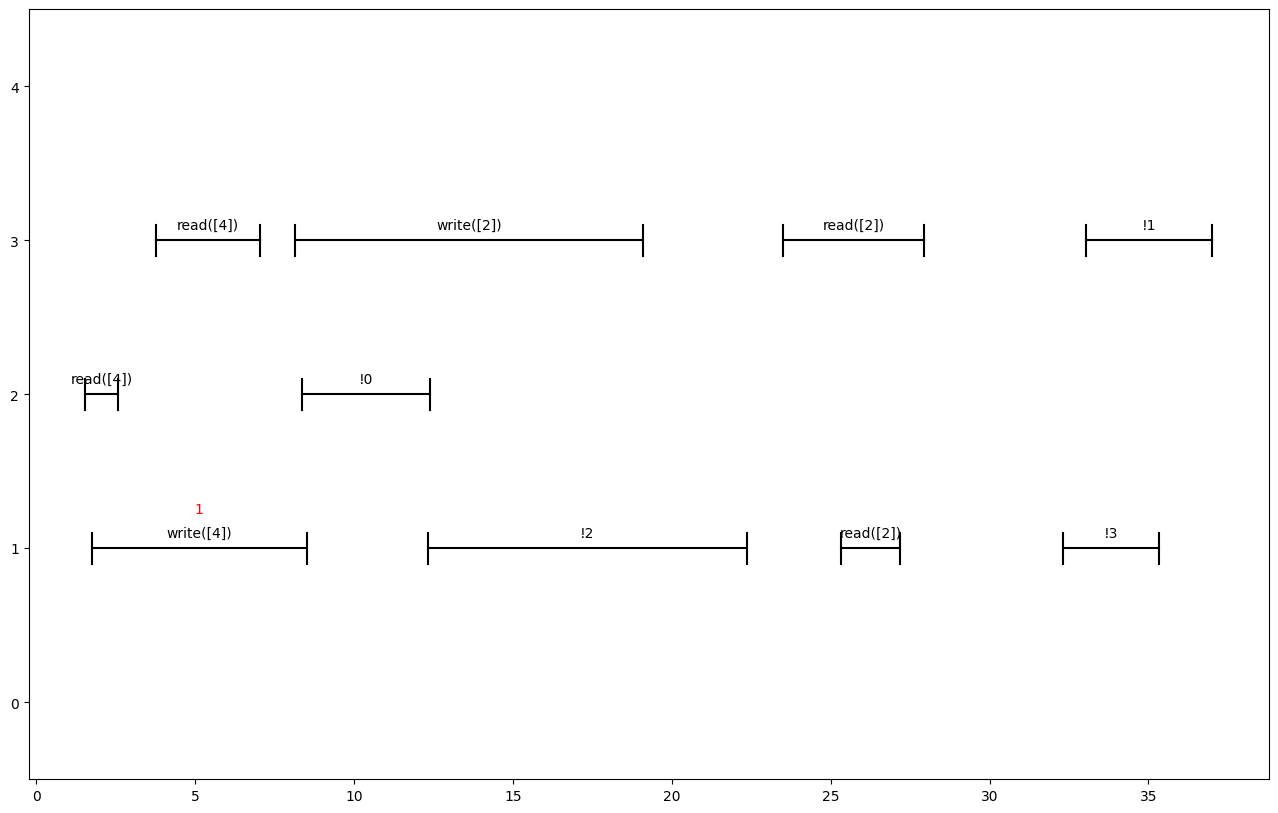

<IPython.core.display.Javascript object>

In [110]:
i = 28
testcase, res = copy.deepcopy(test[i])
print(f"Testcase {i} is {res}")
print(linearize_io(testcase))
visualize_history(testcase)

Testcase 2028 is False


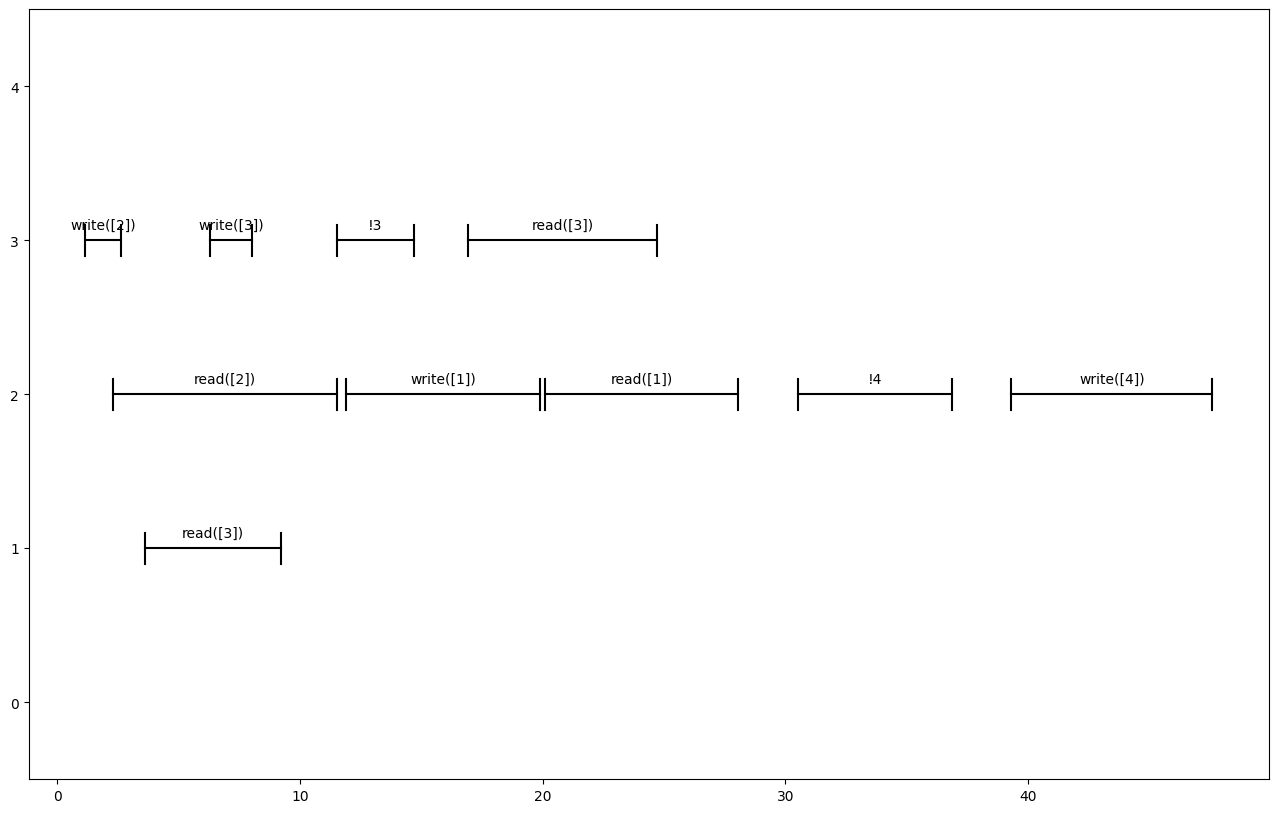

<IPython.core.display.Javascript object>

In [35]:
testcase, res = copy.deepcopy(test[i])
print(f"Testcase {i} is {res}")
visualize_history(testcase)

In [10]:
for wrong_test in wrong_test_no[:10]:
    testcase, res = copy.deepcopy(test[wrong_test])
    print(f"Testcase {wrong_test} is {res}")
    print(linearize_io(testcase))
    visualize_history(testcase)

NameError: name 'wrong_test_no' is not defined

<IPython.core.display.Javascript object>